# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

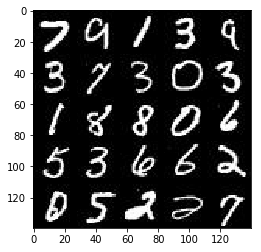

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

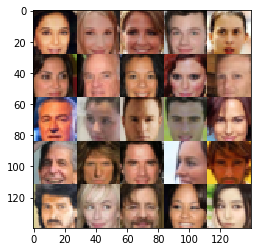

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_imgs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_imgs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        img1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * img1, img1)
        
        
        img2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(img2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        img3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(img3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_r, d_logits_r = discriminator(input_real)
    d_model_f, d_logits_f = discriminator(g_model, reuse=True)
    
    d_loss_r = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_r, labels=tf.ones_like(d_model_r)))
    d_loss_f = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.zeros_like(d_model_f)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.ones_like(d_model_f)))
    
    d_loss = d_loss_r + d_loss_f

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every=100
    learning=learning_rate
    img_width=data_shape[1]
    img_height=data_shape[2]
    img_channels=data_shape[3]
    out_channel_dim=data_shape[3]
    
    input_real,input_z,learning=model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss,g_loss=model_loss(input_real, input_z, out_channel_dim)
    d_opt,g_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                #print(np.max(batch_images)) = 0.5
                #print(np.min(batch_images)) = -0.5
                # Since the value of my batch images is
                scaled_image_input = 2 * batch_images # scaling the image as it was between [-0.5, 0.5]
                
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: scaled_image_input , input_z: batch_z, learning:learning_rate})
                _ = sess.run(g_opt, feed_dict={ input_real: scaled_image_input,input_z: batch_z, learning:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: scaled_image_input, input_z: batch_z, learning:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: scaled_image_input,input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6816... Generator Loss: 0.1325
Epoch 1/2... Discriminator Loss: 2.7609... Generator Loss: 0.2170
Epoch 1/2... Discriminator Loss: 2.4927... Generator Loss: 0.3165
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.5721
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.3156
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 1.6099


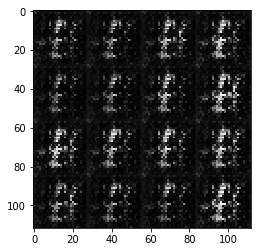

Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 1.7393
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.5309... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 1.8469... Generator Loss: 0.3429


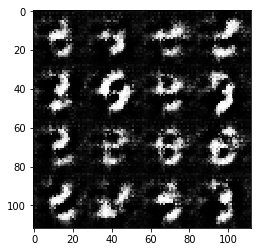

Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.6502... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.6581
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.8856


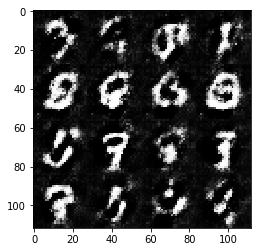

Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 1.2827
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 1.0265
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.5473
Epoch 1/2... Discriminator Loss: 1.2031... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 1.2355
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.8299
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 0.6140


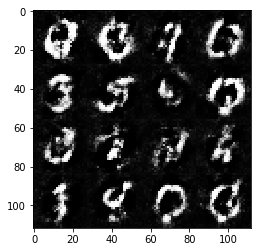

Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 1.4900... Generator Loss: 0.3494
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.4549
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.4617
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.4194


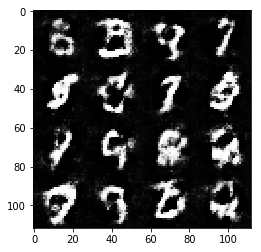

Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.4242
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.3940
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.3821
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.4134
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.3601
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.4080
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.4859
Epoch 1/2... Discriminator Loss: 1.7206... Generator Loss: 0.2512
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.5702


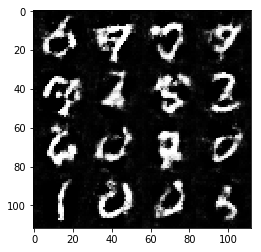

Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.3613
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.9516
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.6721
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.8314


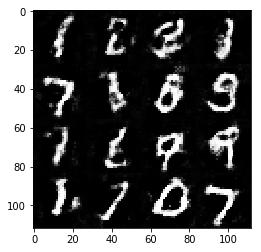

Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.5867... Generator Loss: 0.3009
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.4058
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.4690
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.4143
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.5004
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.6019... Generator Loss: 0.2879


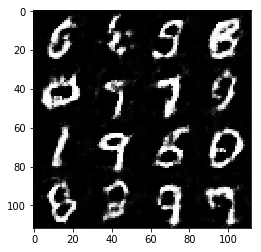

Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.7043
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 0.7018
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 0.4085
Epoch 1/2... Discriminator Loss: 1.4809... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.7108


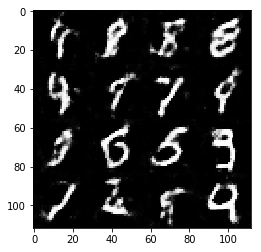

Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.6624
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 0.6445
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.9624
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.5395


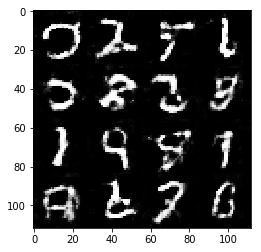

Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.3955
Epoch 2/2... Discriminator Loss: 1.4902... Generator Loss: 0.3365
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.3656
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.4760
Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 1.6195... Generator Loss: 0.2931
Epoch 2/2... Discriminator Loss: 1.5475... Generator Loss: 0.3016
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.4250
Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.3500
Epoch 2/2... Discriminator Loss: 1.4800... Generator Loss: 0.4112


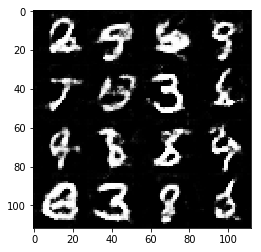

Epoch 2/2... Discriminator Loss: 1.5088... Generator Loss: 0.3382
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.6892
Epoch 2/2... Discriminator Loss: 1.5501... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.5189
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 1.1741


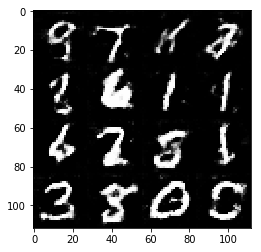

Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 1.6136... Generator Loss: 0.3207
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.3929
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 1.3248
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.9241
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 0.9085


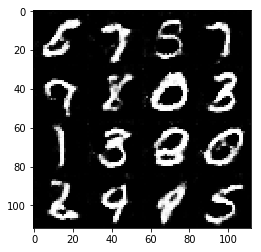

Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.5973
Epoch 2/2... Discriminator Loss: 1.5498... Generator Loss: 0.3157
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.5105
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 0.3105
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 1.5147... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.5566


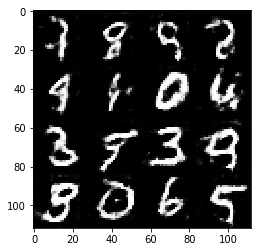

Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.4964
Epoch 2/2... Discriminator Loss: 1.8310... Generator Loss: 0.2064
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.4394
Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.3540
Epoch 2/2... Discriminator Loss: 1.5575... Generator Loss: 0.3068
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.5056
Epoch 2/2... Discriminator Loss: 1.2754... Generator Loss: 0.7169
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.5402
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.6967


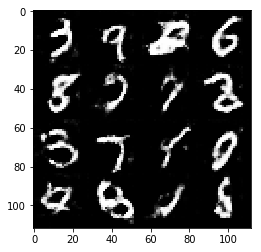

Epoch 2/2... Discriminator Loss: 1.6828... Generator Loss: 0.2639
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.5276
Epoch 2/2... Discriminator Loss: 1.8470... Generator Loss: 0.2148
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.4354
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 1.5320... Generator Loss: 0.3081
Epoch 2/2... Discriminator Loss: 1.5931... Generator Loss: 0.3146
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.4944
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.4555
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.8990


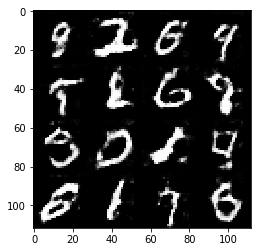

Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.5831
Epoch 2/2... Discriminator Loss: 1.8709... Generator Loss: 0.2049
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.5842
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.6884
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.4238
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 0.3516
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.4451
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.3808


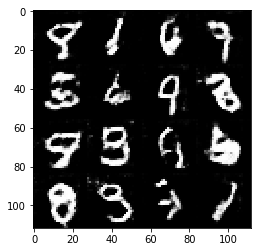

Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.5019
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 1.1006
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 0.4434
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.5248
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.7710... Generator Loss: 0.2230
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.3780
Epoch 2/2... Discriminator Loss: 1.6851... Generator Loss: 0.2624
Epoch 2/2... Discriminator Loss: 1.7017... Generator Loss: 0.2471


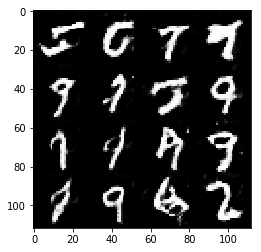

Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.5011
Epoch 2/2... Discriminator Loss: 1.4306... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 0.5714
Epoch 2/2... Discriminator Loss: 1.6528... Generator Loss: 0.2544
Epoch 2/2... Discriminator Loss: 2.0537... Generator Loss: 0.1659
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 0.3822


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 4.8478
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 2.0865
Epoch 1/1... Discriminator Loss: 2.1033... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 2.5942... Generator Loss: 0.1472
Epoch 1/1... Discriminator Loss: 2.1379... Generator Loss: 0.2914
Epoch 1/1... Discriminator Loss: 2.0291... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 2.0152... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 1.9909... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.7586... Generator Loss: 0.3987


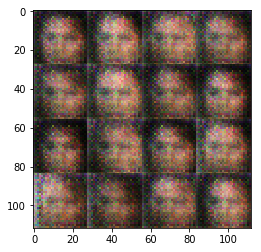

Epoch 1/1... Discriminator Loss: 1.8996... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.7815... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 1.8671... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.9505... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 1.7599... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.7042... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 0.4778


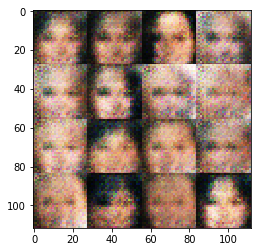

Epoch 1/1... Discriminator Loss: 1.8503... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5530


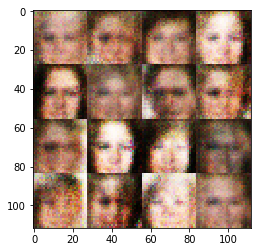

Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.4718


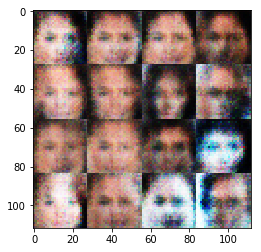

Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6272


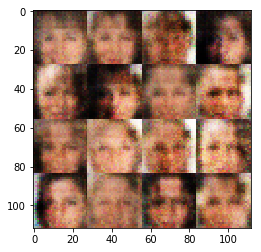

Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6494


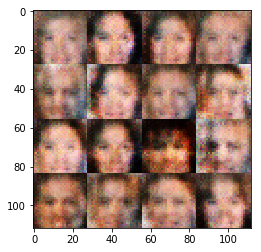

Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6593


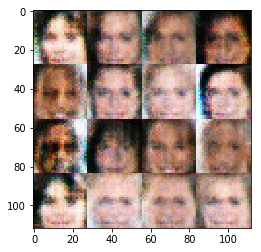

Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6881


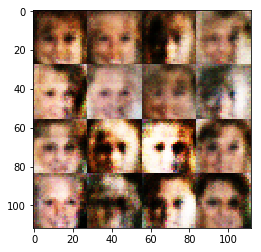

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6797


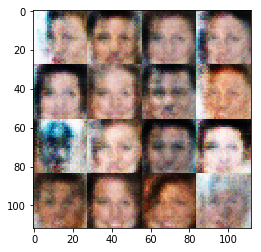

Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6049


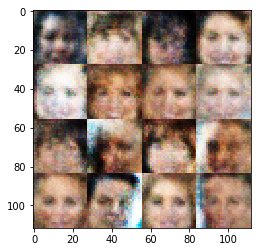

Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6018


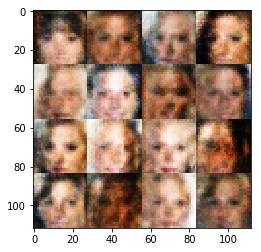

Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6788


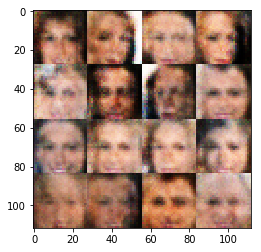

Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6492


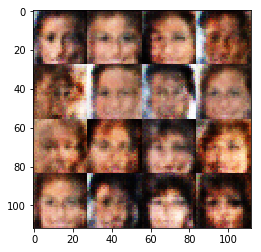

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6898


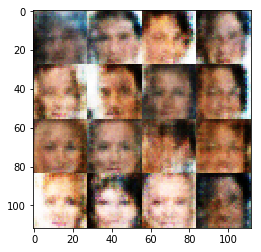

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6705


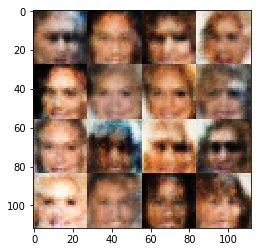

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5977


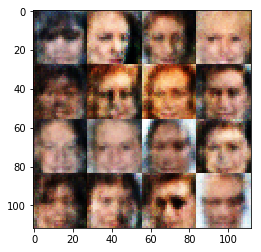

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5501


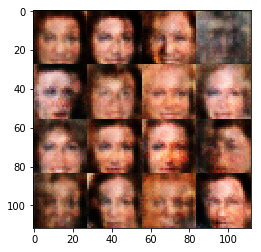

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.4273
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6106


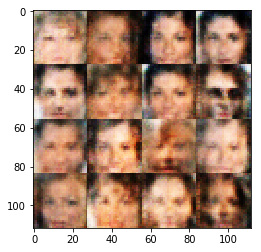

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7018


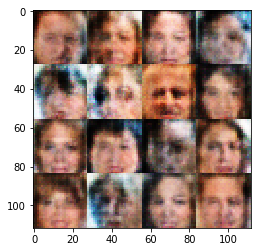

Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5908


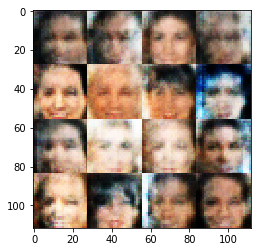

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6208


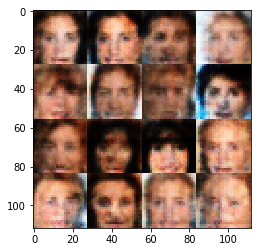

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6807


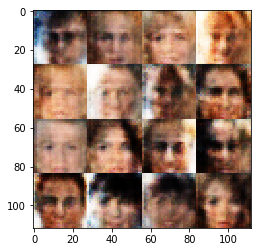

Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7193


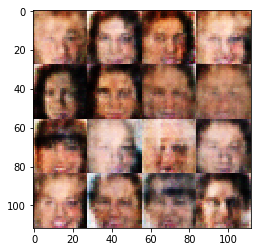

Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6337


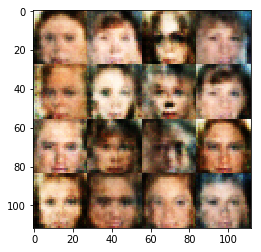

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5921


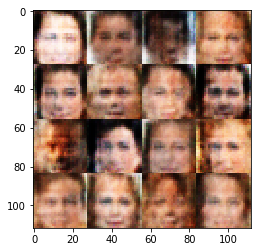

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6399


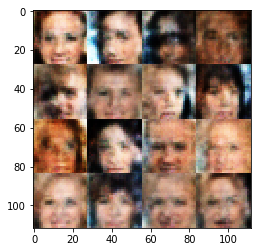

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6912


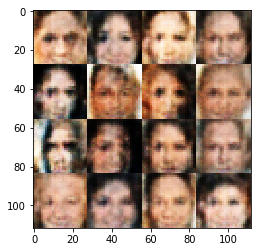

Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7442


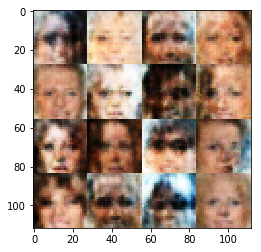

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5576


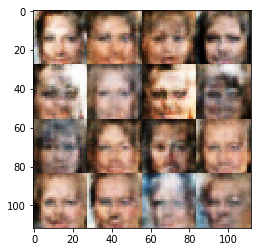

Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.5653


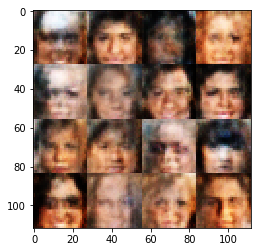

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6745


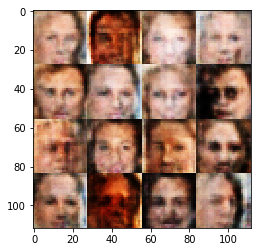

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6375


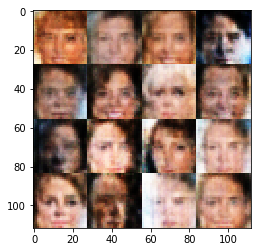

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.5210


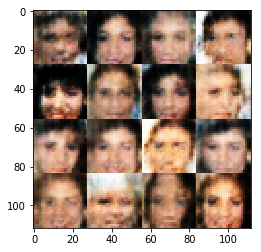

Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5769


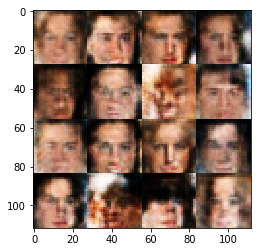

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6310


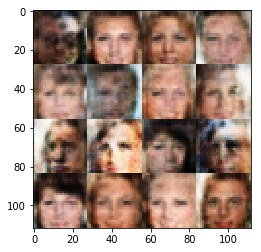

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6669


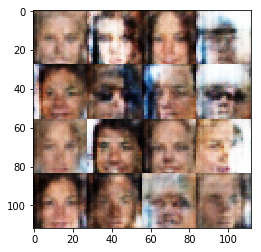

Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7221


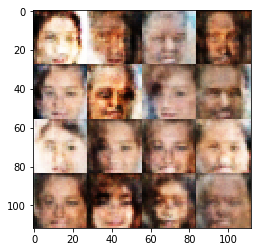

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6104


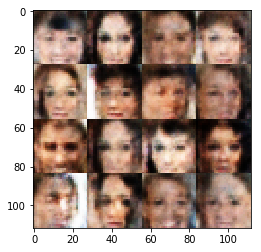

Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6156


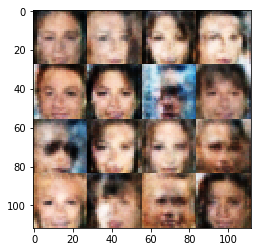

Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.5696


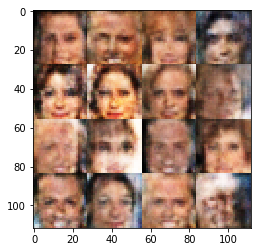

Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.5239


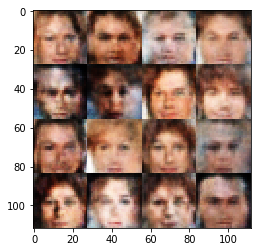

Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7479


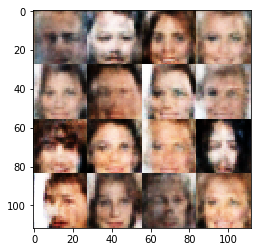

Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6547


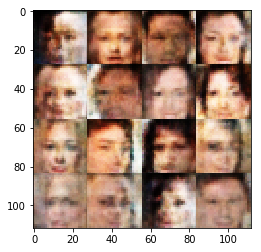

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6956


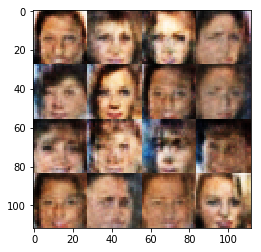

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6781


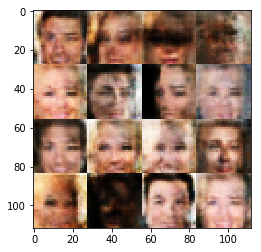

Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6866


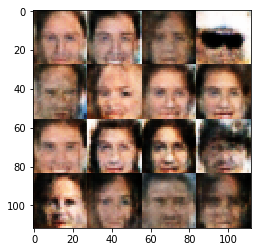

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7485


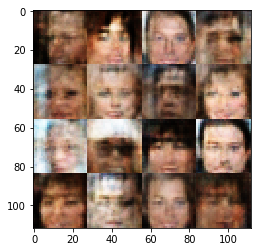

Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7018


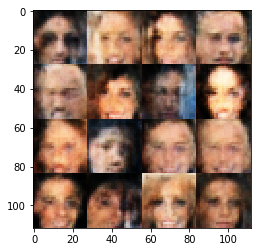

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6604


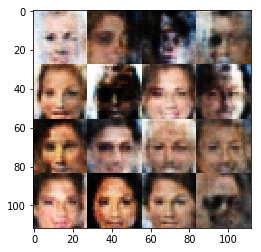

Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6128


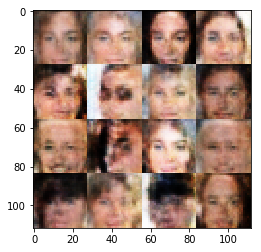

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8481


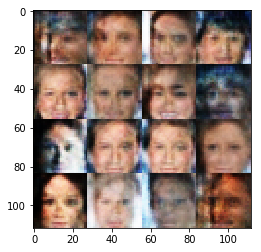

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6585


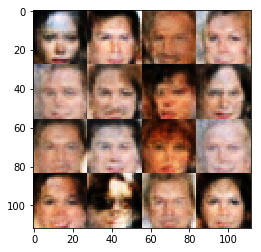

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6581


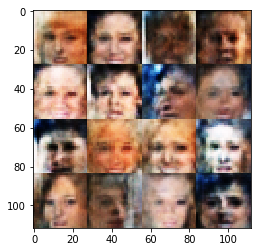

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6899


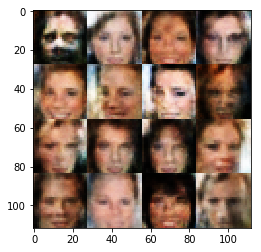

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6458


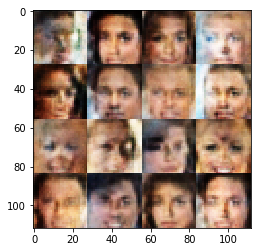

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6979


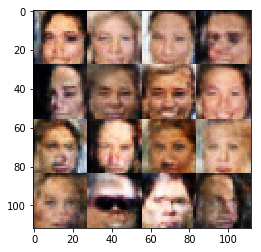

Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6867


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.